# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></div><div class="lev2 toc-item"><a href="#Input" data-toc-modified-id="Input-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Input</a></div><div class="lev3 toc-item"><a href="#Population-structure" data-toc-modified-id="Population-structure-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Population structure</a></div><div class="lev3 toc-item"><a href="#Work-and-education" data-toc-modified-id="Work-and-education-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Work and education</a></div><div class="lev3 toc-item"><a href="#Geodataframe" data-toc-modified-id="Geodataframe-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Geodataframe</a></div><div class="lev2 toc-item"><a href="#Create-the-households" data-toc-modified-id="Create-the-households-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create the households</a></div><div class="lev2 toc-item"><a href="#Here-we-define-the-households" data-toc-modified-id="Here-we-define-the-households-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Here we define the households</a></div><div class="lev2 toc-item"><a href="#Education-and-work" data-toc-modified-id="Education-and-work-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Education and work</a></div><div class="lev2 toc-item"><a href="#Commuting" data-toc-modified-id="Commuting-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Commuting</a></div><div class="lev2 toc-item"><a href="#Create-the-population" data-toc-modified-id="Create-the-population-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Create the population</a></div><div class="lev2 toc-item"><a href="#Plot-the-location-of-households" data-toc-modified-id="Plot-the-location-of-households-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Plot the location of households</a></div><div class="lev2 toc-item"><a href="#Workplaces-creation" data-toc-modified-id="Workplaces-creation-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Workplaces creation</a></div><div class="lev2 toc-item"><a href="#Create-communities" data-toc-modified-id="Create-communities-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Create communities</a></div><div class="lev3 toc-item"><a href="#Demonstrate-how-it-will-work" data-toc-modified-id="Demonstrate-how-it-will-work-191"><span class="toc-item-num">1.9.1&nbsp;&nbsp;</span>Demonstrate how it will work</a></div><div class="lev3 toc-item"><a href="#Alternatively,-KMeans" data-toc-modified-id="Alternatively,-KMeans-192"><span class="toc-item-num">1.9.2&nbsp;&nbsp;</span>Alternatively, KMeans</a></div><div class="lev3 toc-item"><a href="#Comments" data-toc-modified-id="Comments-193"><span class="toc-item-num">1.9.3&nbsp;&nbsp;</span>Comments</a></div><div class="lev3 toc-item"><a href="#Compute-and-append-the-new-codes-to-the-old-ones" data-toc-modified-id="Compute-and-append-the-new-codes-to-the-old-ones-194"><span class="toc-item-num">1.9.4&nbsp;&nbsp;</span>Compute and append the new codes to the old ones</a></div><div class="lev3 toc-item"><a href="#Checkpoint" data-toc-modified-id="Checkpoint-195"><span class="toc-item-num">1.9.5&nbsp;&nbsp;</span>Checkpoint</a></div><div class="lev2 toc-item"><a href="#Split-back-the-dataframe" data-toc-modified-id="Split-back-the-dataframe-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Split back the dataframe</a></div><div class="lev2 toc-item"><a href="#Save-to" data-toc-modified-id="Save-to-111"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Save to</a></div><div class="lev2 toc-item"><a href="#Define-the-types" data-toc-modified-id="Define-the-types-112"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Define the types</a></div><div class="lev2 toc-item"><a href="#Demography" data-toc-modified-id="Demography-113"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>Demography</a></div>

In [2]:
%pylab inline
import pandas as pd
import geopandas as gpd
import shapely

Populating the interactive namespace from numpy and matplotlib


# Overview

In this notebook we show how to generate the households of our synthetic population using the pre-processed Eurostat, ISTAT and geo data.

These steps are presented one by one and their only purpose is to explain what happens internally in the synpop generator.

We are going to load the tables containing the following information:

- regarding household structure:
    - $P^{(NUTS)}(a|s)$ the age $a$ distribution for people living in a given $NUTS$ area given their sex $s$;
    - $P^{(NUTS)}(h)$ the probability to have an household of kind $h$ for each $NUTS$ code;
    - $P^{(NUTS)}(m|h)$ the probability, for each $NUTS$ code, for an household to have $m$ members given the household kind $h$;
    - $P^{(NUTS)}(a|r,h)$ the probability, for each $NUTS$ code, for an household member to have age $a$ given that he is covering the role $r$ (i.e., parent/adult or children) in an household of kind $h$;
- regarding education and employment:
    - the size distribution of schools and workplaces;
    - the probability to attend school at a given age by NUTS2;
    - the probability to have a certain education level given the sex and age by NUTS2;
    - the probability to be employed given sex, age and education level for NUTS2;
    - the commuting probability to other municipalities at given NUTS3 level;
    - we will put a hand-made income distribution as we did not find data on this;
- regarding the geographic and administrative structure:
    - the geodataframe containing the NUTS + LAU1/2 codes of the areas, their extent and their codes;
    - a connection to the geodatabase;
    
## Input

Here we set the location of the input files (pickled dataframes) and we set the global variables.

### Population structure

In [3]:
# The sex strings that will be found in the files
sexDict = {"male": 0, "female": 1}

# The values of the ages to be simulated, extremes included!
ages = range(0, 101, 1)

# The dataframe containing the age distribution (PDF and CDF) of the population per sex for all the NUTS0-3
ageBySex_PDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_ageBySex_PDF.pkl")
ageBySex_CDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_ageBySex_CDF.pkl")

# We also load the data for nuts3 levels (we use them to evaluate the number of agents to create)
popBroadAgeBySex_NUTS3 = pd.read_pickle("resources/Europe/population/structure/dataframes/1990-2016_broadAgeBySexNUTS3.pkl")

# The df containing the distribution of household kind per NUTS2
householdKind_PDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_hhType_PDF.pkl")
householdKind_CDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_hhType_CDF.pkl")

# The df containing the size distribution for each kind of household
householdSizeByKind_PDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_hhsizeByType_PDF.pkl")
householdSizeByKind_CDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_hhsizeByType_CDF.pkl")

# The df containing the age distribution of the population per household type (i.e. which age have the components of households)...
ageByHHrole_PDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_ageByHHstatus_PDF.pkl")
ageByHHrole_CDF = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_ageByHHstatus_CDF.pkl")
ageByHHrole_RAW = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_ageByHHstatus_RAW.pkl")

### Work and education

In [4]:
# The commuting probabilities for each NUTS3
studyCommuting_df = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_studyCommuting_ISTAT_NUTS3.pkl")
workCommuting_df = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_workCommuting_ISTAT_NUTS3.pkl")

# Education indicator...
educationLevelByAge_PDF = pd.read_pickle("resources/Europe/population/structure/dataframes/educationLevel_NUTS2_PDF.pkl")
educationLevelByAge_CDF = pd.read_pickle("resources/Europe/population/structure/dataframes/educationLevel_NUTS2_CDF.pkl")

# School attendance per age...
schoolAttendanceRate_df = pd.read_pickle("resources/Europe/population/structure/dataframes/educationParticipationRate_NUTS2.pkl")

# Employment rate given education...
employmentBySexAgeEdu_df = pd.read_pickle("resources/Europe/population/structure/dataframes/employmentSexAgeEdu_NUTS2.pkl")

# Schools and wp size...
schoolSize_df = pd.read_pickle("resources/Europe/population/structure/dataframes/school_PISA_sizeDistribution_NUTS0.pkl")
workplSize_df = pd.read_pickle("resources/Europe/population/structure/dataframes/wpSizeDistribution_NUTS1.pkl")

### Geodataframe

In [5]:
%%time
# The geodataframe of the Piedimont area...
import pickle, gzip
geoDataFrame = pickle.load(gzip.open("resources/Germany/boundaries/DE_NUTS3_to_LAU2_gdf.pkl.gz", "rb"))
geoDFid2nuts = pickle.load(open("resources/Germany/boundaries/DE_NUTS3_to_LAU2_id2NUTS.pkl", "rb"))
geoDFnuts2id = pickle.load(open("resources/Germany/boundaries/DE_NUTS3_to_LAU2_NUTS2id.pkl", "rb"))

reference_gdf_tot = geoDataFrame[-1]

CPU times: user 1min 47s, sys: 1.18 s, total: 1min 48s
Wall time: 1min 52s


In [6]:
selectedNUTS = "DE1"
reference_gdf = reference_gdf_tot[reference_gdf_tot.l0.apply(lambda v: geoDFid2nuts[v].startswith(selectedNUTS))].copy()

In [7]:
reference_gdf.head(2)

,id,name,admin_level,geometry,code,l0,l1,l2,CELLS_CDF,CELLS_SHP,POP,BARICENTER_X,BARICENTER_Y
57,relation/55222,Wilferdingen,10,"POLYGON ((8.601121300000001 48.9348825, 8.5991...","(23, 3364, 59)",23,3364,59,"[0.03405919774727987, 0.05916390708137263, 0.1...",[(POLYGON ((8.56666666666797 48.94166666667562...,3517.442120,8.586016,48.940809
89,relation/57966,Waldrennach,10,"POLYGON ((8.5965071 48.8078491, 8.597047 48.80...","(23, 196, 91)",23,196,91,"[0.03293391660203041, 0.1050719810211363, 0.10...",[(POLYGON ((8.591666666667955 48.8302696831042...,1455.372665,8.603938,48.827192


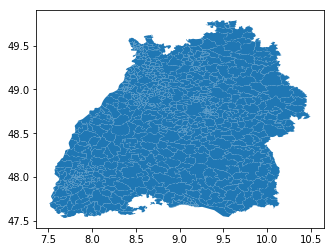

In [8]:
reference_gdf.plot()

In [9]:
reference_gdf.shape

(853, 13)

## Create the households

Here, for each boundary at the finest resolution level (municipalities and/or districts of large cities) we create the population residing there.

First, we have to define generate the possible kind of households.

Each household accept some constraint on the age of the parents (adults) and sons (children), the difference in age etc;
moreover each household type accepts a cdf for the age of the adults and one for the age of the children.

The household class and the relevant functions are in `synpopStructures`.

We will also use utilities from the `synpopUtils` module and a connection to the geodatabase.

In [14]:
import synpopStructures
reload(synpopStructures)

<module 'synpopStructures' from 'synpopStructures.pyc'>

In [15]:
import synpopUtils
reload(synpopUtils)

ImportError: cannot import name __check_build

In [16]:
#import geoMongoUtils
#reload(geoMongoUtils)

In [17]:
#myClient = geoMongoUtils.geoMongoClient(dbURL="127.0.0.1", dbPort=27017, dbUser="ubi15")

In [18]:
#myClient.getCountryLevelCodes()

The `synpopStructures` expects raw counters of houses to be passed as pdf.

In this we alternate the counter of males and females having a given age and participating to a given household kind.

For example:

| $m_0$ | $f_0$ | $m_1$ | $f_1$ | $m_2$ | $f_2$ | ... | ... | $m_{100}$ | $f_{100}$ |


The procedure is simple:
    
- for each level5 code area within the geodataframe:
    - fetch statistics of that area on the household structure and age distribution of components;
    - create the age PDF and the household size/kind distribution accordingly;
    - aggregate the population found in each SEDAC cell in the selected area;
    - create households until population of cells is reproduced;
    - put each household on a random (lon, lat) location within the area proportionally to population;
    - append households to general list;
        
Once we finish we have a list of households made like this:
```
((hhID, hhKind, hhSize), (lon,lat), (nuts3, LAU1, LAU2))
```

and an agents list made like this:
```
[(id, role, sex, age)_0, (id, role, sex, age)_1, ...]
```

We will then assign an education/employment/income, workplace (school) and commuting based on age and sex of each agent accordingly to the given tables.

## Here we define the households

Each household has a structure given by the number of parents, number of sons and age constraints between the parent/son.

We will inform these structures with the age PDF for each NUTS code during the household creation.

In [19]:
# Household labels: the ones for the age structure and the ones for the actual household kinds
ageHouseholdLabels = set(ageByHHrole_RAW.columns.get_level_values(1).unique())
ageHouseholdLabels.discard("TOTAL")

householdLabels = set(householdKind_PDF.columns)
householdLabels.discard("TOTAL")

In [20]:
# Couple without children
CPL_NCH = synpopStructures.householdType(minMaxParents=(2,2), minMaxSons=(0,0), ageMinMaxParents=(18,100), sexParents="etero",
                                         agePDFparents=None, agePDFsons=None)

# Couple with young and/or old children
CPL_WCH = synpopStructures.householdType(minMaxParents=(2,2), minMaxSons=(1,9), ageMinMaxParents=(18,100), ageMinMaxChildren=(0, 80),
                                         dMinMaxParSon=(18,50), sexParents="etero", sexSons="free",
                                         agePDFparents=None, agePDFsons=None,
                                       )

# Lone father/mother with young/old children
M1_CH  = synpopStructures.householdType(minMaxParents=(1,1), minMaxSons=(1,10), ageMinMaxParents=(18,100), ageMinMaxChildren=(0,80),
                                         dMinMaxParSon=(18,50), sexParents="male", sexSons="free",
                                         agePDFparents=None, agePDFsons=None,
                                       )

F1_CH  = synpopStructures.householdType(minMaxParents=(1,1), minMaxSons=(1,10), ageMinMaxParents=(18,100), ageMinMaxChildren=(0,80),
                                         dMinMaxParSon=(18,50), sexParents="female", sexSons="free",
                                         agePDFparents=None, agePDFsons=None,
                                       )

# Singles and multihouseholds share the same age distribution (but different size)
A1_HH  = synpopStructures.householdType(minMaxParents=(1,1), minMaxSons=(0,0), ageMinMaxParents=(15, 100), sexParents="free",
                                         agePDFparents=None, agePDFsons=None,
                                       )
                                        
MULTI_HH  = synpopStructures.householdType(minMaxParents=(2,11), minMaxSons=(0,0), ageMinMaxParents=(15, 100),
                                         sexParents="free", dMinMaxp1p2=(0, 40), dMinMaxParSon=(30, 100), fixedParentsSons=(False, True),
                                         agePDFparents=None, agePDFsons=None,
                                       )

In [21]:
# Save the households in an array and in a dictionary to remember their order.
# We also save the column from which they will inherit the parent and sons
# age PDF from the aggregation.
houseHoldTypeDict = {
        "CPL_NCH":  {"obj": CPL_NCH,  "id": None,
                     'parentAgePDFName': "CPL_XCH",
                     'childsAgePDFName': None,
                    },
        "CPL_WCH":  {"obj": CPL_WCH,  "id": None,
                     'parentAgePDFName': "CPL_XCH",
                     'childsAgePDFName': "CH_PAR",
                    },
        "M1_CH":    {"obj": M1_CH,    "id": None,
                     'parentAgePDFName': "A1_XCH",
                     'childsAgePDFName': "CH_PAR",
                    },
        "F1_CH":    {"obj": F1_CH,    "id": None,
                     'parentAgePDFName': "A1_XCH",
                     'childsAgePDFName': "CH_PAR",
                    },
        "A1_HH":    {"obj": A1_HH,    "id": None,
                     'parentAgePDFName': "A1_HH",
                     'childsAgePDFName': None,
                    },
        "MULTI_HH": {"obj": MULTI_HH, "id": None,
                     'parentAgePDFName': "A1_HH",
                     'childsAgePDFName': None,
                    },
    }

nHouseholdKinds = len(householdLabels)
houseHoldTypeArray = [None]*nHouseholdKinds
for idx, hhLabel in enumerate(householdLabels):
    tmp_householdEntry = houseHoldTypeDict[hhLabel]
    tmp_householdEntry["id"] = idx
    houseHoldTypeArray[idx] = tmp_householdEntry["obj"]
houseHoldTypeArray = np.array(houseHoldTypeArray)

In [22]:
householdLabels

{'A1_HH', 'CPL_NCH', 'CPL_WCH', u'F1_CH', u'M1_CH', 'MULTI_HH'}

## Education and work

Here, using the data on education and employment we define if each agent is attending school, working and which education level it has.

We adopt the following assumptions:
- we adopt 4 schools levels:
    - 0: pre-primary (no primary school), [0, 5) years;
    - 1: primary school [6, 10) years old;
    - 2: secondary school [11, 18) years old;
    - 3: tertiary (university) [18, 25) y.o..
- we assume 3 education levels:
    - 0: agent completed pre-primary and/or primary;
    - 1: agent completed secondary school;
    - 2: agent completed university.
- agents younger than 18 years old that are not following school have education level equal to the previous one of their age (e.g. a 16 y.o. children not attending school has a primary education level);
- workplaces and schools are treated as equal: schools are just workplaces with kind id from 0 to 9 (included), while workplaces have kind id >= 10.
- we assume only one workplace id for real workplaces, id=10.
- due to lack of data we assign an income to the non students employed as follows:
    - if edu = 0 income = Normal(15000, 1000);
    - if edu = 1 income = Normal(25000, 1500);
    - if edu = 2 income = Normal(35000, 2000);
    - if age > 65 and not employed assign an income as in edu = 0.

The procedure, for each agent, is as follows:
- decide if agent goes to school or not:
- if yes, set education to previous level and workplace kind to corresponding school level code (e.g. a 22 y.o. guy going to the University has education level 1=secondary school and workplace id 3=university).
- if not:
    - if age < 18 set education to either 0 or 1, depending on age;
    - else if age >= 18 draw education from education table;
    - then decide whether the agent is working or not accordingly to the employment rate per sex, age and education level.

In [17]:
from synpopGenerator_tools import getEducationRate, getEducationLevelCDF,\
    getEmploymentProba, age2schoolKind, age2defaultEdu, agentSchoolEduEmploy

## Commuting

Now for each LAU2 code we compute its baricenter (in terms of population) and compute the matrix of distances using the *haversine* distance.

We end up with $d_{ij}$ setting the distance (in km) between LAU2 code $i$ and $j$.

From this matrix and from the population $n_i$ of each LAU2 code we compute the origin destination matrix $C_{ij}$ setting the probability to commute from municipality $i$ to $j$. The matrix is derived from the gravity model:

$C_{ij} = \theta \frac{n_i^{\tau_f}n_j^{\tau_t}}{d_{ij}^\rho},\;\; \rm{if } i\neq j$

We use $\tau_f=0.28$, $\tau_t=0.66$ and $\rho=2.95$ as found in Ajelli et al. 2010.

The $\theta$ proportionality constant is set so that the overall commuting probability to other municipalities equals the fraction of people in the area moving outside of teh municipality for work/study.

In particular, from the commuting table we know the probability to commute to the same municipality $p_{sMun} = 1 - p_{dMun}$, so that:

$\sum_{i \neq j}C_{ij} = p_{dMun} = 1 - p_{sMun}$,

and

$C_{ii} = p_{sMun}$

We will define one matrix of commuting for each kind of school/workplace applying the following assumption as in Ajelli et al.:
- for kindergarten, primary and secondary schools we have a maximum travelling distance of 100 km;
- kindergarten and primary schools may be found in every municipality, whereas secondary schools are based in municipalities of at least 15000 people. Universities are found in cityes of at least $10^5$ people. If no cities like this are found we assign universities to the top populated area.

In [18]:
minimumPopulationPerWPkind = {0: 1, 1: 1, 2: 15000, 3: 100000, 10: 10}
maximumDistancePerWPkind = {0: 100, 1: 100, 2: 100, 3: 1000, 10: 1000}

In [19]:
# Compute the distance matrix...
from scipy.spatial.distance import pdist, squareform
from haversine import haversine

baricenters_LatLon = np.array(reference_gdf[["BARICENTER_Y", "BARICENTER_X"]])
baricenters_distanceM = squareform(pdist(baricenters_LatLon, metric=haversine))

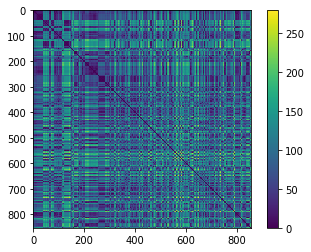

In [20]:
plt.imshow(baricenters_distanceM)
plt.colorbar()

In [21]:
baricenters_distanceM.shape

(853, 853)

In [22]:
#%%time
# Gravity model:
tau_f = .28
tau_t = .66
rho_exp = 2.95

populationI = np.array(reference_gdf["POP"])
topPopulatedArea = np.argmax(populationI)

fractionToSameMunicipalityStudy = studyCommuting_df["PDF", "sMun"]
fractionToSameMunicipalityWork = workCommuting_df["PDF", "sMun"]

Commuting_ij = {wp_k: None for wp_k in minimumPopulationPerWPkind.keys()}

for wp_kind, _ in Commuting_ij.iteritems():
    tmp_commutingM = np.zeros(baricenters_distanceM.shape, dtype=float)
    
    minTargetPop = minimumPopulationPerWPkind[wp_kind]
    maxTargetDist = maximumDistancePerWPkind[wp_kind]
    
    for source in xrange(baricenters_distanceM.shape[0]):
        source_pop = populationI[source]
        if source_pop == 0:
            continue
            
        NUTS3_code = geoDFid2nuts[reference_gdf.iloc[source]["code"][0]]
        if wp_kind < 10:
            fraction_to_same = fractionToSameMunicipalityStudy[NUTS3_code]
        else:
            fraction_to_same = fractionToSameMunicipalityWork[NUTS3_code]
            
        for target in xrange(baricenters_distanceM.shape[1]):
            target_pop = populationI[target]
            distance_ij = baricenters_distanceM[source, target]
        
            if target_pop < minTargetPop or distance_ij > maxTargetDist:
                continue
                
            if source == target:                
                tmp_commutingM[source, target] = fraction_to_same
            else:
                tmp_commutingM[source, target] = (source_pop**tau_f) * (target_pop**tau_t)\
                                                        / max(1., distance_ij**rho_exp)
        # Normalize row...
        tmp_row_sum = tmp_commutingM[source, :].sum()
        if tmp_row_sum == .0:
            # No destinations for this wp kind, asssigning to top populated one...
            tmp_commutingM[source, topPopulatedArea] = 1.
        else:
            # Normalize and restore diagonal...
            # Fraction to same may be 0 because of municipality size (especially for unis)!
            fraction_to_same = tmp_commutingM[source, source]
            amountToOthers = tmp_row_sum - fraction_to_same
            
            tmp_commutingM[source, :] *= (1. - fraction_to_same)/amountToOthers
            tmp_commutingM[source, source] = fraction_to_same
            
        assert np.isclose(tmp_commutingM[source,:].sum(), 1.),\
               "Sum was %f code %r row %r" % (tmp_sum, NUTS3_code, source_pop)
    Commuting_ij[wp_kind] = tmp_commutingM

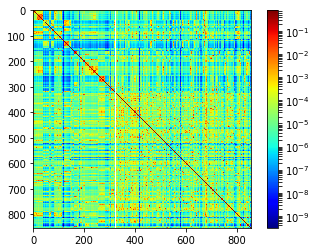

In [23]:
plt.imshow(Commuting_ij[10], norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
plt.colorbar()

In [24]:
# Create the CDF for each wp kind and row...
Commuting_ij_CDF = {k: v.cumsum(axis=1) for k,v in Commuting_ij.iteritems()}

## Create the population

In [25]:
# Scale of the population to save
# Fraction between 0 and 1 
popScale = 1.

# The index position of the attributes...

# Agents
agentIndex_id = 0
agentIndex_hhid = 1
agentIndex_role = 2
agentIndex_sex = 3
agentIndex_age = 4
agentIndex_edu = 5
agentIndex_wpkind = 6
agentIndex_income = 7
agentIndex_wpid = 8

# Households
hhIndex_id = 0
hhIndex_kind = 1
hhIndex_size = 2
hhIndex_lon = 3
hhIndex_lat = 4
hhIndex_geocode = 5

# Workplaces
wpIndex_id = 0
wpIndex_kind = 1
wpIndex_size = 2
wpIndex_lon = 3
wpIndex_lat = 4
wpIndex_geocode = 5

In [26]:
import synpopGenerator_tools
reload(synpopGenerator_tools)

<module 'synpopGenerator_tools' from 'synpopGenerator_tools.pyc'>

In [27]:
#%%time

# Here we set the counters, the container of the generated households
tot_pop, tot_generated_pop = 0, 0
generatedHouseholds = []
generatedAgents = []

# Since we have a lot of municipalities under the same
# NUTS3 we save the last seen NUTS level from which we
# computed the household stats to save time
lastStatisticNUTS = None
lastEducationNUTS = None

# While I am here I also save the set of agents working in
# each workplace kind for each LAU2 index...
workersIdPerLAU = {lau:
                       {kind: set() for kind in minimumPopulationPerWPkind}
                   for lau in reference_gdf.index
                  }

# We have to keep track of the generated agents and 
# households from one area to the other 
incremental_hh_id = 0
incremental_ag_id = 0

counter, total = 1,  reference_gdf.shape[0]
LAU2_df_iIndex = -1
for LAU2_index, LAU2_data in reference_gdf.iterrows():
    LAU2_df_iIndex += 1
    tmp_code = LAU2_data["code"]
    tmp_nuts3_id = tmp_code[0]
    tmp_nuts3_code = geoDFid2nuts[tmp_nuts3_id]
    
    # Look for the code that has statistics for this shape...
    # We need the hh size, kind and component age distributions.
    statisticsNuts = tmp_nuts3_code
    while statisticsNuts not in householdKind_CDF.index:
        statisticsNuts = statisticsNuts[:-1]
    
    if statisticsNuts != lastStatisticNUTS:
        lastStatisticNUTS = statisticsNuts
        
        # Compute the statistics for the new area...
        # The household type distribution
        houseHoldTypeCDF = np.array(householdKind_CDF.loc[statisticsNuts])
        houseHoldTypePDF = np.array(householdKind_PDF.loc[statisticsNuts])

        # The size distribution for each household type distribution
        houseHoldType_sizeCDF = np.array([householdSizeByKind_CDF[k].loc[statisticsNuts] for k in householdLabels])
        houseHoldType_sizePDF = np.array([householdSizeByKind_PDF[k].loc[statisticsNuts] for k in householdLabels])
    

        # The age distribution for male and female for parents and children of each household type
        ageRAWparentSonHHtype = {}
        for hhKind in ageHouseholdLabels:
            # The raw numbers
            tmp_arra = np.column_stack((ageByHHrole_RAW[("male",   hhKind)].loc[statisticsNuts],
                                        ageByHHrole_RAW[("female", hhKind)].loc[statisticsNuts]))
            # Put it in a row and divide by sum...
            tmp_arra = tmp_arra.flatten(order="C")
            ageRAWparentSonHHtype[hhKind] = tmp_arra/max(1., tmp_arra.sum())
            
        # Inform the household about the newly computed age pdf...
        for hhName, hhData in houseHoldTypeDict.iteritems():
            tmp_obj = hhData["obj"]
            
            par_name = hhData["parentAgePDFName"]
            if par_name:
                tmp_obj.setAgePDFparents(ageRAWparentSonHHtype[par_name])
                
            son_name = hhData["childsAgePDFName"]
            if son_name:
                tmp_obj.setAgePDFsons(ageRAWparentSonHHtype[son_name])
                
    educationNUTS = tmp_nuts3_code
    while educationNUTS not in schoolAttendanceRate_df["2013"].index:
        educationNUTS = educationNUTS[:-1]
        
    if educationNUTS != lastEducationNUTS:
        # Save info about education and employment
        lastEducationNUTS = educationNUTS
        eduRate = synpopGenerator_tools.getEducationRate(schoolAttendanceRate_df["2013"].loc[educationNUTS])
        eduLevelCDF = synpopGenerator_tools.getEducationLevelCDF(educationLevelByAge_CDF["2011"].loc[educationNUTS])
        employPerSexAgeEdu = synpopGenerator_tools.getEmploymentProba(employmentBySexAgeEdu_df["2011"].loc[educationNUTS])

    # Setting reference to the cells CDF and their shapes...
    cellsCDF = LAU2_data["CELLS_CDF"]
    if len(cellsCDF) < 1:
        print "\nNo cells found within code %s name %s" % (tmp_code, LAU2_data["name"])
        continue
    cellsIntersectionSHP = LAU2_data["CELLS_SHP"]
    popToGenerate = int(LAU2_data["POP"]*popScale)
    
    if popToGenerate == 0:
        continue
    
    # The households for the NUTS3. Since we do not have eurostat data at this level we use
    # the sedac cells for an estimation of the population...
    tmp_hhs, tmp_agents = synpopStructures.generatePopulation(
                            houseHoldType=houseHoldTypeArray, houseHoldTypeCDF=houseHoldTypeCDF,
                            houseHoldType_sizeCDF=houseHoldType_sizeCDF, size=popToGenerate,
                            offset_agID=incremental_ag_id, offset_hhID=incremental_hh_id
                        )
    incremental_hh_id += len(tmp_hhs)
    incremental_ag_id += len(tmp_agents)
    
    tmp_gen_pop = len(tmp_agents)
    while tmp_hhs:
        # Now assign each household to the corresponding cell proportionally to the population density.
        tmp_hh = tmp_hhs.pop(0)
        point = synpopUtils.assignToCell(cellsCDF=cellsCDF,
                                         cellsIntersectionSHP=cellsIntersectionSHP)
        tmp_hh = tmp_hh + [point.x, point.y, tmp_code]
        generatedHouseholds.append(tmp_hh)
    
    # Compute edu, income and employment for current agents...
    # Then, if employed, assign to a destination based on the
    # origin destination matrix...
    tmp_agents = [agentSchoolEduEmploy(
                                agent=agent, eduRate=eduRate, eduLevel=eduLevelCDF,
                                employAgeSexEduRate=employPerSexAgeEdu
                            ) for agent in tmp_agents]
    
    for agent in tmp_agents:
        tmp_wp_kind = agent[agentIndex_wpkind]
        if tmp_wp_kind < 0:
            agent.append(-1)
        else:
            selected_destination = np.argmax(np.random.rand() < Commuting_ij_CDF[tmp_wp_kind][LAU2_df_iIndex,:])
            selected_destination_index = reference_gdf.index[selected_destination]
            # Save the id in the corresponding set and append the workplace LAU id to the agent
            # (will be later substituted with the wpid)...
            workersIdPerLAU[selected_destination_index][tmp_wp_kind].add(agent[agentIndex_id])
            agent.append(selected_destination_index)
    
    generatedAgents.extend(tmp_agents)
        
    tot_pop += popToGenerate
    tot_generated_pop += tmp_gen_pop
    
    sys.stdout.write("\r%04d / %04d: stat NUTS %r - Code %r - Name %r                                           "
                     % (counter, total, statisticsNuts,  tmp_code, LAU2_data["name"]))
    sys.stdout.flush()
    counter += 1
    
print "\nTOT", tot_pop, "GEN", tot_generated_pop
print "\nDone!"

0853 / 0853: stat NUTS u'DE14' - Code (41, 4775, 9748) - Name u'Bodenseekreis'                                                                                           
TOT 10641949 GEN 10642726

Done!


## Plot the location of households

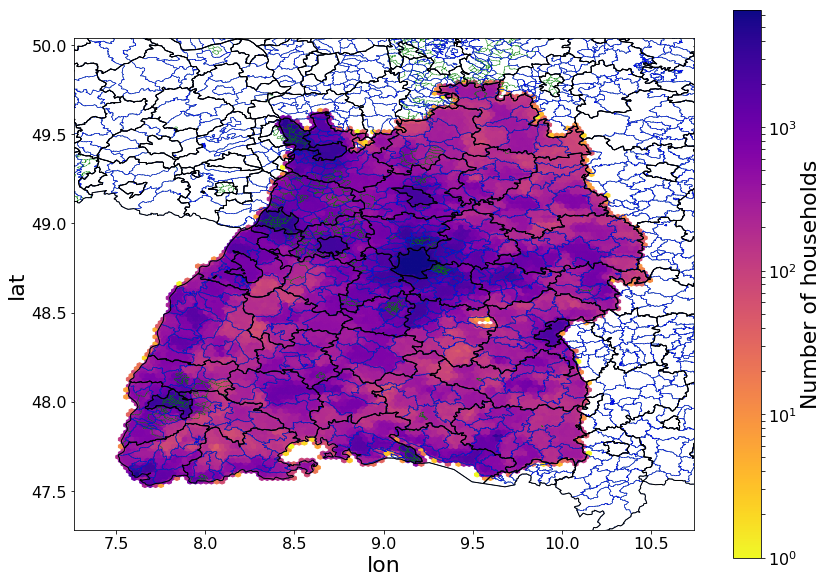

In [28]:
selectedNUTS = "DE1"

xys = np.array([[h[hhIndex_lon], h[hhIndex_lat]]
                    for h in generatedHouseholds
                        if geoDFid2nuts[h[hhIndex_geocode][0]][:len(selectedNUTS)] == selectedNUTS])
xs = xys[:,0]
ys = xys[:,1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
ax.set_aspect('equal')

res = plt.hexbin(xs, ys, cmap=plt.cm.plasma_r, mincnt=1, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(shrink=.65)
cbar.set_label("Number of households", size=22)
cbar.ax.tick_params(labelsize=16)

geoDataFrame[2].plot(ax=ax, color="none", edgecolor="green", linestyle="--", lw=.5, alpha=.8)
geoDataFrame[1].plot(ax=ax, color="none", edgecolor="blue", linestyle="-", lw=.5, alpha=.7)
geoDataFrame[0].plot(ax=ax, color="none", edgecolor="black")

plt.xlim(xs.min()-.25, xs.max()+.25)
plt.ylim(ys.min()-.25, ys.max()+.25)

plt.xlabel("lon", size=22)
plt.ylabel("lat", size=22)

plt.xticks(size=16)
plt.yticks(size=16)

plt.tight_layout()
plt.savefig("figures/synPop_2011_%s_hhSpatialDistribution.pdf" % selectedNUTS, bbox_inches="tight")

## Workplaces creation

Now for each LAU we collect the workers of that lad (for each workplace kind) and we generate a workplace 

In [29]:
# Define the workplaces
# For universities (wp=3) we have a unique, empirical size distribution N(2500, 100).
workplacesDict = {k: synpopStructures.workplace(k) for k in minimumPopulationPerWPkind}

In [30]:
from scipy.stats import norm

universityBins = np.arange(1000, 4100, 100)
universityPDF = norm.pdf(universityBins[:-1], loc=2500, scale=200)
universityCDF = {"BINS": universityBins,
                 "CDF": universityPDF.cumsum()/universityPDF.sum(),
                 "PDF": universityPDF,
                }

workplacesDict[3].set_sizeCDF(universityCDF)

In [31]:
#%%time
# The last nuts from which I took stats
# the incremental counter of the wp id and
# the list of the created workplaces...
lastStatisticNUTSschool = None
lastStatisticNUTSwork = None
incremental_wp_id = 0
generatedWorkplaces = []

for LAU2_code, LAU2_data in reference_gdf.iterrows():
    LAU2_geoCode = LAU2_data["code"]
    NUTS3_index = LAU2_geoCode[0]
    NUTS3_code = geoDFid2nuts[NUTS3_index]
    
    # Update information on size CDF of school and workplaces...
    statisticsNutsSchool = NUTS3_code
    while statisticsNutsSchool not in schoolSize_df.index:
        statisticsNutsSchool = statisticsNutsSchool[:-1]
    if statisticsNutsSchool != lastStatisticNUTSschool:
        lastStatisticNUTSschool = statisticsNutsSchool
        
        for wpkind in range(3):
            workplacesDict[wpkind].set_sizeCDF(schoolSize_df.loc[statisticsNutsSchool][["BINS", "CDF"]])
    
    statisticsNutsWork = NUTS3_code
    while statisticsNutsWork not in workplSize_df.index:
        statisticsNutsWork = statisticsNutsWork[:-1]
    if statisticsNutsWork != lastStatisticNUTSwork:
        lastStatisticNUTSwork = statisticsNutsWork
        
        for wpkind in range(10, 11):
            workplacesDict[wpkind].set_sizeCDF(workplSize_df.loc[statisticsNutsWork][["BINS", "CDF"]])
    
    # Retrieve cells CDF and shapes to place workplaces in space...
    cellsCDF = LAU2_data["CELLS_CDF"]
    cellsIntersectionSHP = LAU2_data["CELLS_SHP"]
    
    # Now create workplaces/schools...
    for wp_kind, workers_id in workersIdPerLAU[LAU2_code].iteritems():
        tmp_wp_obj = workplacesDict[wp_kind]
        
        # We cast the set of ids to a list, shuffle it once
        # and then pop from the list the desired number of agents ids...
        assigned, toAssign = 0, list(workers_id)
        np.random.shuffle(toAssign)
        
        nToAssign = len(toAssign)
        while assigned < nToAssign:
            tmp_wp = tmp_wp_obj.makeOne(incremental_wp_id)
            
            # Check how many workers are left to assign and update the
            # real size of the workplace...
            assigned_now = tmp_wp[wpIndex_size]
            assigned_now = min(nToAssign-assigned, assigned_now)
            tmp_wp[wpIndex_size] = assigned_now
            
            for agent_id in toAssign[assigned:assigned+assigned_now]:
                generatedAgents[agent_id][agentIndex_wpid] = incremental_wp_id
                
            # Put the workplace in a cell...
            point = synpopUtils.assignToCell(cellsCDF=cellsCDF,
                                         cellsIntersectionSHP=cellsIntersectionSHP)
            tmp_wp = tmp_wp + [point.x, point.y, LAU2_geoCode]
            generatedWorkplaces.append(tmp_wp)
            
            incremental_wp_id += 1
            assigned += assigned_now
            
    sys.stdout.write("\rCode %r number %05d of %05d" % (NUTS3_code, LAU2_code+1, reference_gdf.shape[0]))
    sys.stdout.flush()

Code u'DE147' number 09749 of 00853

## Create communities

Now that we created the population we can group the households and workplaces in groups finer than municipality.
To do this we developed a hierarchical clustering method based either on the *hierarchical clustering* with maximum distance or the iterative *KMeans* clustering.

As it turns out the KMeans method is more flexible and efficient, at the price of a slightly longer running time.

We accomplish this by setting the hierarchical levels we want to add and a target size for each of this levels.

Now we have the geocode that is formed by (NUTS3, municipality, district). We assume that the district division is not enough so we want to add the following levels:

- neighborhood: groups of ~5000 people;
- community: groups of ~800 people;
- household cluster/buinding: groups of ~90 people.

In [32]:
levelsTargetSize = [5000, 800, 90]

### Demonstrate how it will work

We generate `N` points at random in the (0,1) square.

As found [here](https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering):

*Methods of single linkage and centroid belong to so called space contracting, or “chaining”. That means - roughly speaking - that they tend to attach objects one by one to clusters, and so they demonstrate relatively smooth growth of curve “% of clustered objects”. On the contrary, methods of complete linkage, Ward’s, sum-of-squares, increase of variance, and variance commonly get considerable share of objects clustered even on early steps, and then proceed merging yet those – therefore their curve “% of clustered objects” is steep from the first steps. These methods are called space dilating. Other methods fall in-between.*

We build the dendogram and then try to find all the clusters of selected size.

In [33]:
import numpy as np

In [34]:
# Try with a population of N people in a square/circle
N = 11000
cc = np.array([.5,.5])
radiusSquared = .25

xys = np.zeros((N,2))
pps = np.zeros((N,2))
i = 0
while i < N:
    pp = np.random.rand(1,2)
    if ((pp-cc)**2).sum(axis=1) <= radiusSquared:
        xys[i,:] = pp
        pps[i,:] = pp
        i += 1

In [35]:
%%time
clusteringResults, linkageMatrix = synpopUtils.hierarchicallyCluster(xys, levelsTargetSize=levelsTargetSize, method="ward")

CPU times: user 2.93 s, sys: 484 ms, total: 3.41 s
Wall time: 3.41 s


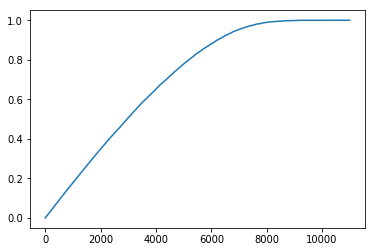

In [36]:
# Plot the percent of clustered objects
xxx = synpopUtils.percentClustered(linkageMatrix)
plt.plot(xxx)

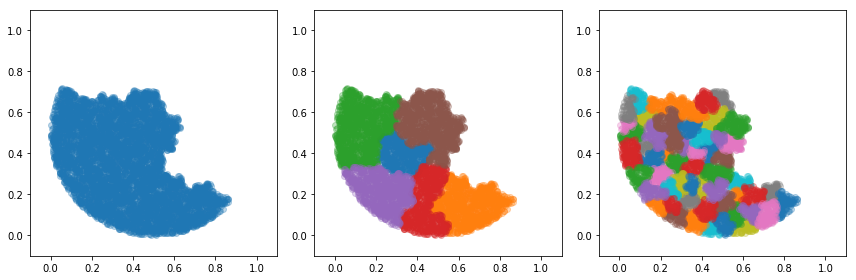

In [37]:
fig = plt.figure()
synpopUtils.visualizeHierarchicalResults(clusteringResults, xys, fig=fig)

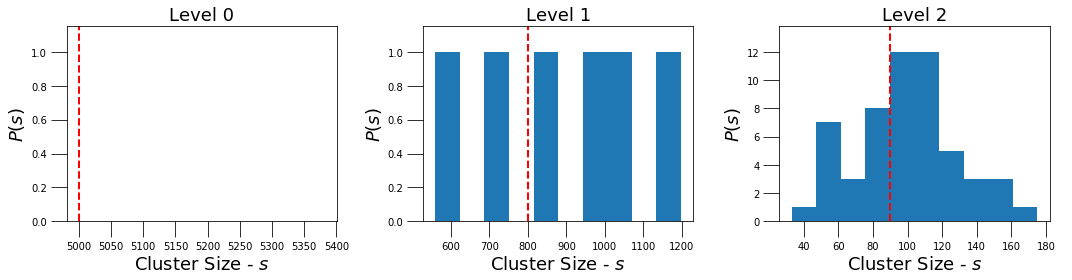

In [38]:
fig = plt.figure()
synpopUtils.plotHierarchicalSizePerLevel(clusteringResults, levelsTargetSize, fig)

### Alternatively, KMeans

The hierarchical clustering has three main problems:
1. it is not easy to deal with leaf nodes that join a large cluster at later stages (we have a lot of dandling leafes)
- it is hard to enforce the size of each layer while maintaining the geographical proximity.
- it is cumbersome to impose a given number of clusters to be found per hierarchical level.

That is why we switch to an easier approach: **KMeans**.

This approach is straightforward:
- pick up `N` households;
- look for `N/size_0` clusters (where `size_0` is the size of the highest level) of size about `size_0`:
    - for each cluster look for `size_0/size_1` clusters among the given points;
        - repeat for each level unti all population is clustered;
        
Besides the cluster number $k$, the relevant parameter of the `KMeans` method is the initiation procedure:
- `k-means++` assigns to each point a label among the k labels;
- `random` picks up k points from the systems and use them as initial centroids of the clusters.

In uniformly distributed data as our there is no clear evidence to prefer one over the other;

In [56]:
import synpopUtils
reload(synpopUtils)

<module 'synpopUtils' from 'synpopUtils.py'>

In [40]:
%%time
nClustersPerLevel = [N/float(levelTargetSize) for levelTargetSize in levelsTargetSize]
resultsKMeans = synpopUtils.clusterPointsInLevelsBottomUp(xys, nClustersPerLevel=nClustersPerLevel, n_init=4, sampleFrac=1.)

CPU times: user 18.5 s, sys: 4.64 s, total: 23.2 s
Wall time: 25.2 s


In [41]:
%%time
nClustersPerLevel = [N/float(levelTargetSize) for levelTargetSize in levelsTargetSize]
print nClustersPerLevel
resultsKMeans = synpopUtils.clusterPointsInLevelsBottomUp(xys, nClustersPerLevel=nClustersPerLevel, n_init=4, sampleFrac=.1)

[2.2, 13.75, 122.22222222222223]
CPU times: user 18.1 s, sys: 4.88 s, total: 23 s
Wall time: 24.2 s


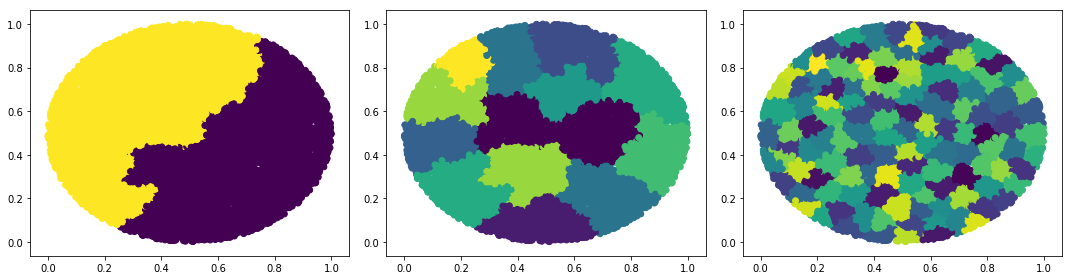

In [42]:
fig = plt.figure()
synpopUtils.visualizeKMeansResults(resultsKMeans, pps, fig)
plt.tight_layout()
plt.savefig("figures/synpop_clusteringLocal_KMEANS.pdf", bbox_inches="tight")

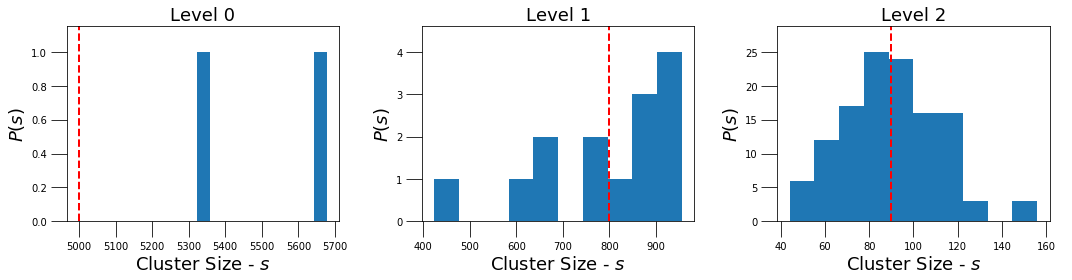

In [43]:
fig = plt.figure()
synpopUtils.plotKMeansSizePerLevel(resultsKMeans, levelsTargetSize, fig)
plt.tight_layout()
plt.savefig("figures/synpop_clusteringLocal_levelSizes_KMEANS.pdf", bbox_inches="tight")

### Comments

**KMeans** is able to deal with diverse and partition sizes close from one level to the other in a very clean and direct way.

Moreover, it is implemented in parallel thus the performances should scale with number of cores.

Besides, it is **MUCH MORE** memory performant and scales well with the number of households.

Last but not least it can handle both small and large populations with respect to the largest level of division.

That is why we adopt it in the following.

### Compute and append the new codes to the old ones

Now for all the households and workplaces falling in a municipality we apply the procedure above to compute the indices.

To simplify the procedure we convert households and workplaces to a dataframe and use indexing and slicing schemes.

In [44]:
generatedHouseholds[0]

[0, 1, 4, 8.564592826120819, 48.94341678514491, (23, 3364, 59)]

In [45]:
generatedWorkplaces[0]

[0, 0, 170, 8.590250697525398, 48.939238811877175, (23, 3364, 59)]

In [46]:
hhdf = pd.DataFrame(generatedHouseholds, columns=["id", "kind", "size", "lon", "lat", "geocode"])
hhdf.set_index("id", inplace=True)
nHouseholds = hhdf.shape[0]

wpdf = pd.DataFrame(generatedWorkplaces, columns=["id", "kind", "size", "lon", "lat", "geocode"])
wpdf.set_index("id", inplace=True)
nWorkplaces = wpdf.shape[0]

wpdf.head()

,kind,size,lon,lat,geocode
id,,,,,
0,0,170,8.590251,48.939239,"(23, 3364, 59)"
1,1,210,8.605047,48.923608,"(23, 3364, 59)"
2,10,8,8.576120,48.947636,"(23, 3364, 59)"
3,10,6,8.581424,48.941305,"(23, 3364, 59)"
4,10,8,8.587470,48.939138,"(23, 3364, 59)"


In [47]:
hhdf.head()

,kind,size,lon,lat,geocode
id,,,,,
0,1,4,8.564593,48.943417,"(23, 3364, 59)"
1,5,2,8.561716,48.943559,"(23, 3364, 59)"
2,1,4,8.568205,48.949743,"(23, 3364, 59)"
3,4,1,8.601305,48.931887,"(23, 3364, 59)"
4,1,4,8.568224,48.943473,"(23, 3364, 59)"


In [48]:
locationsDF = hhdf.append(wpdf, ignore_index=True, verify_integrity=True)
locationsDF.head()

,kind,size,lon,lat,geocode
0,1,4,8.564593,48.943417,"(23, 3364, 59)"
1,5,2,8.561716,48.943559,"(23, 3364, 59)"
2,1,4,8.568205,48.949743,"(23, 3364, 59)"
3,4,1,8.601305,48.931887,"(23, 3364, 59)"
4,1,4,8.568224,48.943473,"(23, 3364, 59)"


In [49]:
# Agents df...
generatedAgents_DF = pd.DataFrame(generatedAgents, columns=["id", "hh", "role", "sex", "age", "edu", "employed", "income", "wp"])
generatedAgents_DF.head()

,id,hh,role,sex,age,edu,employed,income,wp
0,0,0,1,1,39,0,10,14668.528485,3342
1,1,0,1,0,33,1,10,31986.467859,14124
2,2,0,0,1,5,0,1,0.000000,1
3,3,0,0,0,7,0,1,0.000000,1
4,4,1,1,1,41,1,10,30933.584809,28


### Checkpoint

In [50]:
hhdf.to_pickle("checkpoint_HH.pkl")
wpdf.to_pickle("checkpoint_WP.pkl")
locationsDF.to_pickle("checkpoint_LO.pkl")
generatedAgents_DF.to_pickle("checkpoint_AG.pkl")

In [60]:
tmp_res

array([[  1,   2,  30],
       [  1,   2,  54],
       [  1,   2, 110],
       ...,
       [  0,   5,   3],
       [  1,   2,  16],
       [  1,  12,  66]], dtype=int32)

In [64]:
nClustersPerLevel

[1, 1, 10]

In [66]:
import synpopUtils
reload(synpopUtils)

<module 'synpopUtils' from 'synpopUtils.py'>

In [68]:
from sklearn.cluster import KMeans

In [70]:
xs = np.random.rand(1,2)
m = KMeans(n_clusters=1)
m.fit(xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [73]:
synpopUtils.clusterPointsInLevelsBottomUp(xys=xys, nClustersPerLevel=[1,1,10])

array([[0, 0, 6],
       [0, 0, 1],
       [0, 0, 9],
       ...,
       [0, 0, 0],
       [0, 0, 9],
       [0, 0, 7]], dtype=int32)

In [72]:
nClustersPerLevel

[1, 1, 10]

In [74]:
#%%time

# Prepare the new column for the local code...
nLevelsToAdd = len(levelsTargetSize)
localCodeCols = ["lo_code_%d" % i for i in range(nLevelsToAdd)]
for col in localCodeCols:
    locationsDF[col] = -1

ini_idx, fin_idx = -1, -1
i = 0
for tmp_geocode, tmp_group in locationsDF.groupby("geocode"):
    i += 1
    sys.stdout.write("\r%04d / %04d" % (i, reference_gdf.shape[0]))
    sys.stdout.flush()
    
    if i < ini_idx:
        continue
        
    xys = np.array(tmp_group[["lon", "lat"]])
    ids = tmp_group.index
    N = reference_gdf[reference_gdf["code"] == tmp_geocode]["POP"].values[0]*popScale
    nClustersPerLevel = [max(1, int(N/float(levelTargetSize))) for levelTargetSize in levelsTargetSize]
    if nClustersPerLevel[-1] > 1:
        tmp_res = synpopUtils.clusterPointsInLevelsBottomUp(xys=xys, nClustersPerLevel=nClustersPerLevel,
                                                            n_init=5, sampleFrac=.2)
    else:
        # All in one cluster...
        tmp_res = np.zeros(shape=(xys.shape[0], nLevelsToAdd), dtype=int)
    
    locationsDF.loc[ids, localCodeCols] = tmp_res
    
    if i == fin_idx:
        break

0853 / 0853

In [75]:
locationsDF[locationsDF["lo_code_0"] >= 0].head()

,kind,size,lon,lat,geocode,lo_code_0,lo_code_1,lo_code_2
177147,4,1,9.037820,48.553127,"(36, 3376, 809)",0,2,20
177148,3,2,9.027464,48.549161,"(36, 3376, 809)",0,2,4
177149,1,5,9.047486,48.544251,"(36, 3376, 809)",0,3,37
177150,4,1,9.048091,48.545946,"(36, 3376, 809)",0,1,11
177151,4,1,9.024806,48.553047,"(36, 3376, 809)",0,2,18


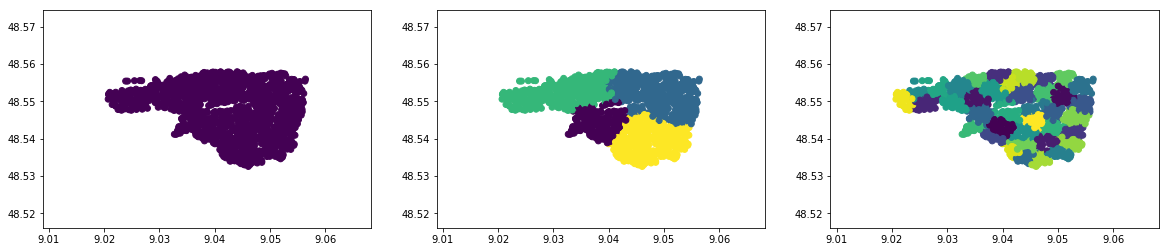

In [82]:
tmp_df = locationsDF[locationsDF["lo_code_0"] >= 0].iloc[:1500]
plt.figure(figsize=(20,4))

for l in range(3):
    plt.subplot(1,3,l+1)
    plt.scatter(tmp_df["lon"], tmp_df["lat"], c=tmp_df["lo_code_%d" % l])

## Split back the dataframe

In [83]:
# Uncompress the nuts code
lenGeoCode = len(locationsDF["geocode"].iloc[0])
lenLocalCode = nLevelsToAdd

for level in range(lenGeoCode+lenLocalCode):
    label = "l%d" % level
    locationsDF[label] = -1
    if level < lenGeoCode:
        locationsDF[label] = locationsDF["geocode"].apply(lambda v: v[level])
    else:
        locationsDF[label] = locationsDF["lo_code_%d" % (level-lenGeoCode)]


generatedHouseholds_DF = locationsDF.loc[:nHouseholds].copy(deep=True)
generatedHouseholds_DF.reset_index(inplace=True)
generatedHouseholds_DF.rename(columns={"index": "id"}, inplace=True)

generatedWorkplaces_DF = locationsDF.loc[nHouseholds:].copy(deep=True)
generatedWorkplaces_DF.set_index(np.arange(generatedWorkplaces_DF.shape[0]), inplace=True)
generatedWorkplaces_DF.reset_index(inplace=True)
generatedWorkplaces_DF.rename(columns={"index": "id"}, inplace=True)

del generatedWorkplaces_DF["geocode"]
del generatedHouseholds_DF["geocode"]
for col in localCodeCols:
    del generatedHouseholds_DF[col]
    del generatedWorkplaces_DF[col]

In [84]:
generatedHouseholds_DF.head()

,id,kind,size,lon,lat,l0,l1,l2,l3,l4,l5
0,0,1,4,8.564593,48.943417,23,3364,59,-1,-1,-1
1,1,5,2,8.561716,48.943559,23,3364,59,-1,-1,-1
2,2,1,4,8.568205,48.949743,23,3364,59,-1,-1,-1
3,3,4,1,8.601305,48.931887,23,3364,59,-1,-1,-1
4,4,1,4,8.568224,48.943473,23,3364,59,-1,-1,-1


In [85]:
generatedHouseholds[:5]

[[0, 1, 4, 8.564592826120819, 48.94341678514491, (23, 3364, 59)],
 [1, 5, 2, 8.561716042892316, 48.94355854429323, (23, 3364, 59)],
 [2, 1, 4, 8.568204650865031, 48.9497432410455, (23, 3364, 59)],
 [3, 4, 1, 8.601305461388462, 48.93188682068428, (23, 3364, 59)],
 [4, 1, 4, 8.568223974164576, 48.94347284337501, (23, 3364, 59)]]

In [86]:
generatedWorkplaces_DF.head()

,id,kind,size,lon,lat,l0,l1,l2,l3,l4,l5
0,0,0,170,8.590251,48.939239,23,3364,59,-1,-1,-1
1,1,1,210,8.605047,48.923608,23,3364,59,-1,-1,-1
2,2,10,8,8.576120,48.947636,23,3364,59,-1,-1,-1
3,3,10,6,8.581424,48.941305,23,3364,59,-1,-1,-1
4,4,10,8,8.587470,48.939138,23,3364,59,-1,-1,-1


In [87]:
generatedWorkplaces[:5]

[[0, 0, 170, 8.590250697525398, 48.939238811877175, (23, 3364, 59)],
 [1, 1, 210, 8.605046599994846, 48.923608257717625, (23, 3364, 59)],
 [2, 10, 8, 8.576120258853013, 48.94763573291836, (23, 3364, 59)],
 [3, 10, 6, 8.581423990184597, 48.94130506390155, (23, 3364, 59)],
 [4, 10, 8, 8.587469671924286, 48.93913769532983, (23, 3364, 59)]]

## Save to 

In [88]:
import h5py

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [89]:
fout = h5py.File("resources/Germany/synthPop_DE1_100pc_2011.h5", mode="w")
#fout = h5py.File("resources/Italy/TURBO_PROVA.h5", mode="w")
fout.clear()

In [90]:
# Agents table

typeNames =   ["id",  "hh",  "role", "sex", "age", "edu", "employed", "income", "wp"]
typeFormats = ["<i8", "<i8", "<i8",  "<i8", "<i8", "<i8", "<i8",      "<f8",    "<i8"]
itemsize = len(typeFormats)*8
typeOffset = range(0, itemsize, 8)
agentType = np.dtype({"names": typeNames, "formats": typeFormats, })

dataAsMatrix = generatedAgents_DF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=agentType)

fout.create_dataset(name="agent", dtype=agentType, data=dataAsMatrix)

<HDF5 dataset "agent": shape (10642726,), type "|V72">

In [91]:
generatedAgents_DF.head(1)

,id,hh,role,sex,age,edu,employed,income,wp
0,0,0,1,1,39,0,10,14668.528485,3342


In [92]:
fout["agent"][0]

(0, 0, 1, 1, 39, 0, 10, 14668.52848487, 3342)

In [93]:
# Household table

typeNames =   ["id",  "kind", "size", "lon", "lat", "l0",  "l1",  "l2",  "l3",  "l4", "l5"]
typeFormats = ["<i8", "<i8",  "<i8",  "<f8", "<f8", "<i8", "<i8", "<i8", "<i8", "<i8", "<i8"]

householdType = np.dtype({"names": typeNames, "formats": typeFormats, }) 

dataAsMatrix = generatedHouseholds_DF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=householdType)

fout.create_dataset(name="household", dtype=householdType, data=dataAsMatrix)

<HDF5 dataset "household": shape (4914351,), type "|V88">

In [94]:
generatedHouseholds_DF.head(1)

,id,kind,size,lon,lat,l0,l1,l2,l3,l4,l5
0,0,1,4,8.564593,48.943417,23,3364,59,-1,-1,-1


In [95]:
fout["household"][0]

(0, 1, 4, 8.56459283, 48.94341679, 23, 3364, 59, -1, -1, -1)

In [96]:
# Workplaces table

typeNames =   ["id",  "kind", "size", "lon", "lat", "l0",  "l1",  "l2",  "l3",  "l4", "l5"]
typeFormats = ["<i8", "<i8",  "<i8",  "<f8", "<f8", "<i8", "<i8", "<i8", "<i8", "<i8", "<i8"]

workplaceType = np.dtype({"names": typeNames, "formats": typeFormats,}) 

dataAsMatrix = generatedWorkplaces_DF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=workplaceType)

fout.create_dataset(name="workplace", dtype=workplaceType, data=dataAsMatrix)

<HDF5 dataset "workplace": shape (426263,), type "|V88">

In [97]:
generatedWorkplaces_DF.head(1)

,id,kind,size,lon,lat,l0,l1,l2,l3,l4,l5
0,0,0,170,8.590251,48.939239,23,3364,59,-1,-1,-1


In [98]:
fout["workplace"][0]

(0, 0, 170, 8.5902507, 48.93923881, 23, 3364, 59, -1, -1, -1)

## Define the types

In [99]:
type_group = fout.create_group("types")

In [100]:
type_group["agent"] = agentType
type_group["household"] = householdType
type_group["workplace"] = workplaceType

## Demography

We load the natality and mortality tables and we save the data for the NUTS codes in the synthetic population.
Also, we convert the dates of the original dataframe to be in a given time range for simulations.

In [101]:
natality_df = pd.read_pickle("resources/Europe/population/demography/birthRates_1990-2015_age_nuts2_PANDAS.pkl")
mortality_df = pd.read_pickle("resources/Europe/population/demography/deathRates_1990-2015_sexAge_nuts2_PANDAS.pkl")

In [102]:
natality_df.head()

1990                                     ... 2015                      \
sex     0                                     ...    1                       
age   1   2   3   4   5   6   7   8   9   10  ...  91  92  93  94  95  96    
nuts                                          ...                            
AL      0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AL0     0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT      0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT1     0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT11    0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   

                      
sex                   
age  97  98  99  100  
nuts                  
AL     0   0   0   0  
AL0    0   0   0   0  
AT     0   0   0   0  
AT1    0   0   0   0  
AT11   0   0   0   0  

[5 rows x 5200 columns]

In [103]:
geoDFnuts2id.keys()

Index([u'DE111', u'DE112', u'DE113', u'DE114', u'DE115', u'DE116', u'DE117',
       u'DE118', u'DE119', u'DE11A',
       ...
       u'DEG0F', u'DEG0G', u'DEG0H', u'DEG0I', u'DEG0J', u'DEG0K', u'DEG0L',
       u'DEG0M', u'DEG0N', u'DEG0P'],
      dtype='object', length=402)

In [104]:
demographyLevel = 1
dateFormat = "%Y%m%d"
outData = []

for tmp_nuts_code, tmp_nuts_id in geoDFnuts2id.iteritems():
    # The NUTS codes we have to fetch from the table...
    tmp_stat_code = tmp_nuts_code
    while tmp_stat_code not in natality_df.index:
        tmp_stat_code = tmp_stat_code[:-1]
    
    for year in natality_df.columns.get_level_values(0).unique():
        if year < 2002: continue
        for sex in [0, 1]:
            for age in range(1, 101):
                tmp_row = [tmp_nuts_id, datetime.datetime(year, 1, 2).strftime(dateFormat), sex, age]
                tmp_column = tuple([year, sex, age])
                outData.append(tmp_row + [natality_df[tmp_column][tmp_stat_code], mortality_df[tmp_column][tmp_stat_code]])

In [105]:
demographyDF = pd.DataFrame(outData, columns=["l%d"%d for d in range(demographyLevel)] + ["date", "sex", "age", "natality", "mortality"])
demographyDF.head()

,l0,date,sex,age,natality,mortality
0,0,20020102,0,1,0.0,0.00034
1,0,20020102,0,2,0.0,0.00033
2,0,20020102,0,3,0.0,0.00019
3,0,20020102,0,4,0.0,0.00009
4,0,20020102,0,5,0.0,0.00004


In [106]:
# Create fake dates
import datetime
currentDates = demographyDF.date.unique()
numberOfDates = len(currentDates)
timeDeltaPerDate = datetime.timedelta(days=int(np.ceil(200./numberOfDates)))
dateZero = datetime.datetime(2015,1,1,0,0,0)
old2newDates = {oldDate: (dateZero+timeDeltaPerDate*iii).strftime(dateFormat) for iii, oldDate in enumerate(currentDates)}

In [107]:
demographyDF.replace(to_replace={"date": old2newDates}, inplace=True)
demographyDF.head()

,l0,date,sex,age,natality,mortality
0,0,20150101,0,1,0.0,0.00034
1,0,20150101,0,2,0.0,0.00033
2,0,20150101,0,3,0.0,0.00019
3,0,20150101,0,4,0.0,0.00009
4,0,20150101,0,5,0.0,0.00004


In [108]:
demographyDF.date.unique()

array(['20150101', '20150116', '20150131', '20150215', '20150302',
       '20150317', '20150401', '20150416', '20150501', '20150516',
       '20150531', '20150615', '20150630', '20150715'], dtype=object)

In [109]:
# Demography table

typeNames =   ["l%d" % d for d in range(demographyLevel)] + ["date", "sex", "age", "natality", "mortality"]
typeFormats = ["<i8"]*demographyLevel + ["S8", "<i8",  "<i8",  "<f8", "<f8"]

demographyType = np.dtype({"names": typeNames, "formats": typeFormats,}) 

dataAsMatrix = demographyDF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=demographyType)

fout.create_dataset(name="demography", dtype=demographyType, data=dataAsMatrix)

<HDF5 dataset "demography": shape (1125600,), type "|V48">

In [110]:
# Check correspondence
demographyDF.head()

,l0,date,sex,age,natality,mortality
0,0,20150101,0,1,0.0,0.00034
1,0,20150101,0,2,0.0,0.00033
2,0,20150101,0,3,0.0,0.00019
3,0,20150101,0,4,0.0,0.00009
4,0,20150101,0,5,0.0,0.00004


In [111]:
fout["demography"][:5]

array([(0, '20150101', 0, 1, 0., 3.4e-04),
       (0, '20150101', 0, 2, 0., 3.3e-04),
       (0, '20150101', 0, 3, 0., 1.9e-04),
       (0, '20150101', 0, 4, 0., 9.0e-05),
       (0, '20150101', 0, 5, 0., 4.0e-05)],
      dtype=[('l0', '<i8'), ('date', 'S8'), ('sex', '<i8'), ('age', '<i8'), ('natality', '<f8'), ('mortality', '<f8')])

In [112]:
fout.close()